In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/synthetic-hr-burnout-dataset/synthetic_employee_burnout.csv


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [64]:
# Set visualization style
plt.style.use('seaborn')
%matplotlib inline

## 1. Data Exploration and EDA

In [65]:
# Load the data
df = pd.read_csv('/kaggle/input/synthetic-hr-burnout-dataset/synthetic_employee_burnout.csv')
df.head()

,Name,Age,Gender,JobRole,Experience,WorkHoursPerWeek,RemoteRatio,SatisfactionLevel,StressLevel,Burnout
0,Max Ivanov,32,Male,Analyst,3,60,21,4.40,1,0
1,Max Wang,40,Female,Engineer,9,47,67,2.09,2,0
2,Nina Petrov,33,Female,Engineer,2,44,20,2.58,3,0
3,John Ivanov,35,Female,Manager,6,44,70,3.23,8,0
4,John Wang,59,Male,Sales,8,38,46,4.41,1,0


In [66]:
# Display basic information
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe(include='all'))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               2000 non-null   object 
 1   Age                2000 non-null   int64  
 2   Gender             2000 non-null   object 
 3   JobRole            2000 non-null   object 
 4   Experience         2000 non-null   int64  
 5   WorkHoursPerWeek   2000 non-null   int64  
 6   RemoteRatio        2000 non-null   int64  
 7   SatisfactionLevel  2000 non-null   float64
 8   StressLevel        2000 non-null   int64  
 9   Burnout            2000 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 156.4+ KB
None

Summary Statistics:
            Name          Age Gender  JobRole   Experience  WorkHoursPerWeek  \
count       2000  2000.000000   2000     2000  2000.000000       2000.000000   
unique       100          NaN      2        5        

In [67]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Name                 0
Age                  0
Gender               0
JobRole              0
Experience           0
WorkHoursPerWeek     0
RemoteRatio          0
SatisfactionLevel    0
StressLevel          0
Burnout              0
dtype: int64


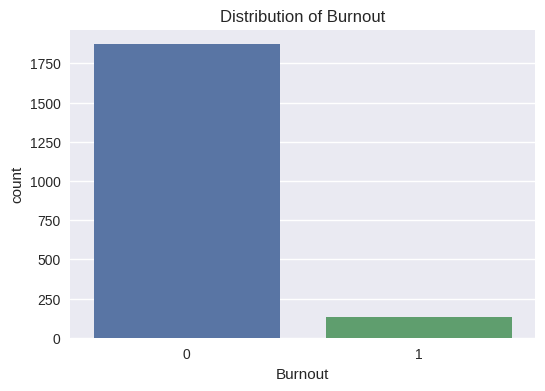

In [68]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Burnout', data=df)
plt.title('Distribution of Burnout')
plt.show()

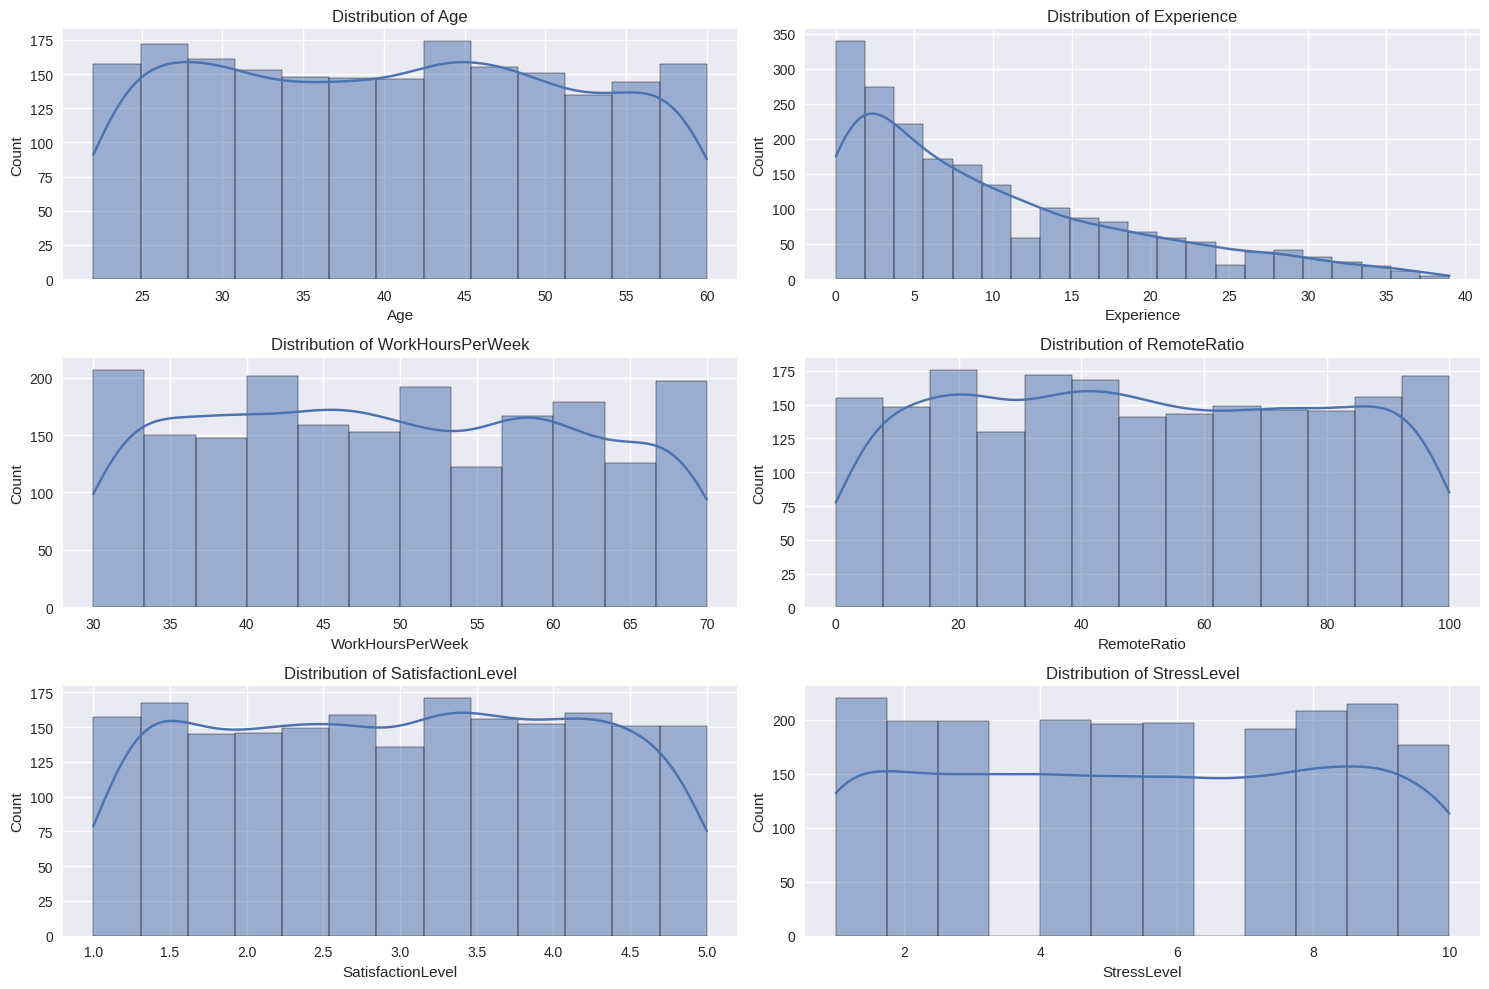

In [69]:
# Distribution of numerical features
numerical_cols = ['Age', 'Experience', 'WorkHoursPerWeek', 'RemoteRatio', 'SatisfactionLevel', 'StressLevel']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

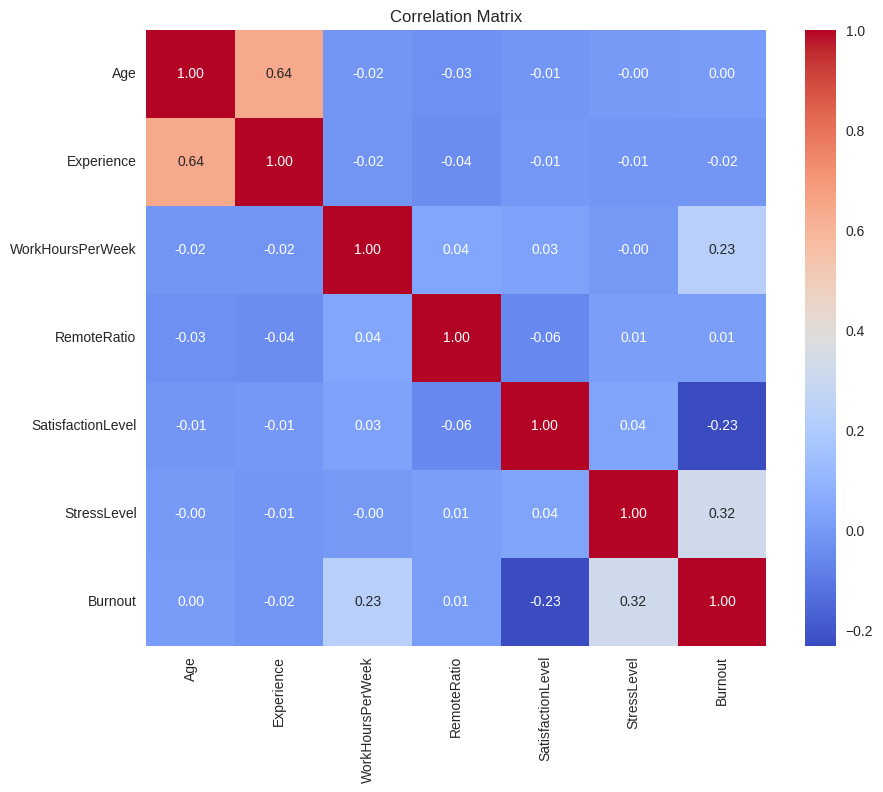

In [70]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['Burnout']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

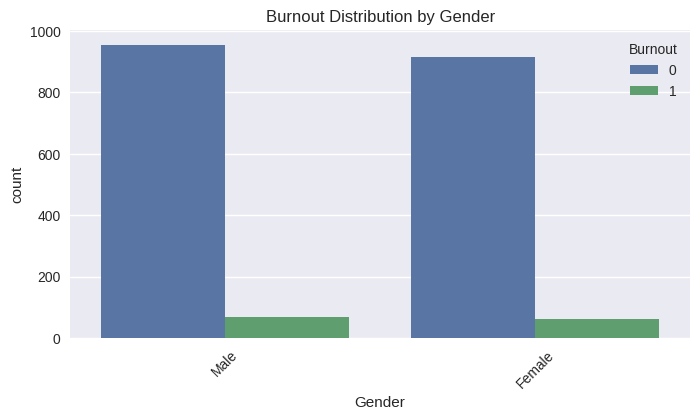

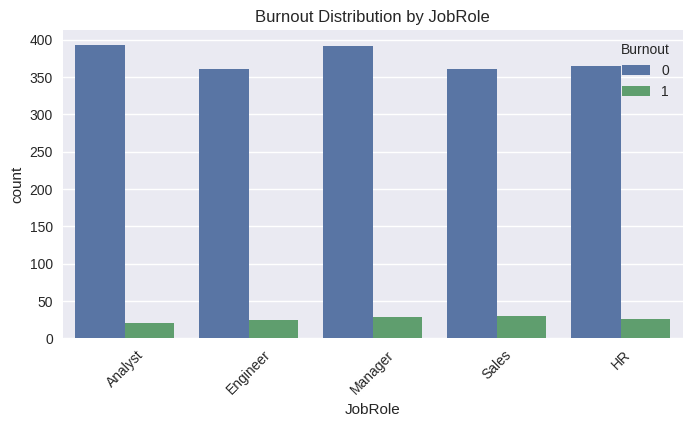

In [71]:
# Categorical feature analysis
categorical_cols = ['Gender', 'JobRole']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Burnout', data=df)
    plt.title(f'Burnout Distribution by {col}')
    plt.xticks(rotation=45)
    plt.show()

#### **Analysis of Results**

**1. Target Distribution:**

- The plot shows a severe imbalance, with around 1750 instances of no burnout and just about 250 instances of burnout. We will have to handle this class imbalance in modeling.

**2. Categorical Feature Analysis:**

- **Burnout Distribution by JobRole:** All roles (Analyst, Engineer, Manager, Sales, HR) have a majority of non-burnout cases, with HR showing slightly more burnout instances compared to others. This suggests job role may have a minor influence on burnout.
- **Burnout Distribution by Gender:** Both genders have a majority of non-burnout cases, with burnout cases. This means that there is no strong gender-based disparity in burnout prevalence.

**3. Numerical Feature Distributions:**

- Age and Experience histograms show a right-skewed distribution, with peaks around 35-40 and 5-10 years, respectively.
- WorkHoursPerWeek is relatively uniform between 35-65 hours, with a peak around 50.
- RemoteRatio is bimodal, with peaks around 20 and 80, reflecting distinct remote work patterns.
- SatisfactionLevel is roughly uniform between 1-5, with a slight dip around 3-4.
- StressLevel is multimodal, with notable peaks at 2, 5, and 8, indicating varying stress levels across employees.

**4. Correlation Matrix:**

- Strong positive correlations exist between Age and Experience, and moderate correlations between WorkHoursPerWeek and Burnout, StressLevel and Burnout, and a negative correlation between SatisfactionLevel and Burnout.
- StressLevel shows the highest correlation with Burnout, suggesting it’s a key predictor, while SatisfactionLevel’s negative correlation indicates lower satisfaction is associated with burnout.

## 2. Data Preprocessing

In [72]:
# Drop Name column
df_processed = df.drop('Name', axis=1)

In [73]:
# Encode categorical variables
le_gender = LabelEncoder()
le_jobrole = LabelEncoder()
df_processed['Gender'] = le_gender.fit_transform(df_processed['Gender'])
df_processed['JobRole'] = le_jobrole.fit_transform(df_processed['JobRole'])

In [74]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'Experience', 'WorkHoursPerWeek', 'RemoteRatio', 'SatisfactionLevel', 'StressLevel']
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

In [75]:
# Handle class imbalance using oversampling
df_majority = df_processed[df_processed['Burnout'] == 0]
df_minority = df_processed[df_processed['Burnout'] == 1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=len(df_majority)//3,  # Upsample to ~33% of majority class
                                 random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [76]:
# Create a copy for hyperparameter tuning
df_model = df_balanced.copy()

In [77]:
# Split features and target
X = df_model.drop('Burnout', axis=1)
y = df_model['Burnout']

In [78]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Feature Engineering

In [79]:
# Make copies for feature engineering
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

In [80]:
# Add interaction terms and ratios
X_train_eng['WorkStressInteraction'] = X_train_eng['WorkHoursPerWeek'] * X_train_eng['StressLevel']
X_train_eng['SatisfactionStressRatio'] = X_train_eng['SatisfactionLevel'] / (X_train_eng['StressLevel'] + 1e-5)  # Avoid division by zero
X_test_eng['WorkStressInteraction'] = X_test_eng['WorkHoursPerWeek'] * X_test_eng['StressLevel']
X_test_eng['SatisfactionStressRatio'] = X_test_eng['SatisfactionLevel'] / (X_test_eng['StressLevel'] + 1e-5)

## 5. Model Selection and Training

In [81]:
# Initialize models
log_reg = LogisticRegression(random_state=42, max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

In [82]:
# Train and evaluate models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_clf, 'Gradient Boosting': gb_clf}
results = {}

for name, model in models.items():
    model.fit(X_train_eng, y_train)
    y_pred = model.predict(X_test_eng)
    results[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       374
           1       0.86      0.86      0.86       125

    accuracy                           0.93       499
   macro avg       0.91      0.91      0.91       499
weighted avg       0.93      0.93      0.93       499

Confusion Matrix:
[[357  17]
 [ 17 108]]

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       125

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499

Confusion Matrix:
[[374   0]
 [  0 125]]

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       125

    accuracy      

In [83]:
# Store best model based on F1-score 
best_model_name = max(results, key=lambda x: results[x]['classification_report']['weighted avg']['f1-score'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


**Note:** 

- The perfect scores across both ensemble models are suspicious given the dataset size of 2494 entries and the introduction of synthetic data via oversampling.
- This could indicate data leakage or insufficient model regularization. The engineered features may also have introduced strong predictors that the models exploited perfectly.
- The Logistic Regression model, while less performant, provides a more realistic baseline, suggesting the ensemble models may be overfitting to the training data.
- We will perform hyperparameter tuning using GridSearchCV to address potential overfitting and validate the Random Forest model.

## 6. Hyperparameter Tuning

In [84]:
# Define feature engineering function
def engineer_features(X):
    X = X.copy()
    X['WorkStressInteraction'] = X['WorkHoursPerWeek'] * X['StressLevel']
    X['SatisfactionStressRatio'] = X['SatisfactionLevel'] / (X['StressLevel'] + 1e-5)  # Avoid division by zero
    return X

In [85]:
# Create a transformer for feature engineering
feature_engineering = FunctionTransformer(engineer_features)

In [86]:
# Prepare features and target from the preserved copy
X = df_model.drop('Burnout', axis=1)
y = df_model['Burnout']

In [87]:
# Define parameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

In [88]:
# Create pipeline
pipeline = Pipeline([
    ('engineer', feature_engineering),
    ('rf', RandomForestClassifier(random_state=42))
])

In [89]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('engineer',
                                        FunctionTransformer(func=<function engineer_features at 0x7a6a43fa2fc0>)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20, 30, None],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [90]:
# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [91]:
# Evaluate on test set
y_pred = best_rf.predict(X_test_eng)
print("\nTuned Random Forest Results:")
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Tuned Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       125

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499

Confusion Matrix:
[[374   0]
 [  0 125]]


**Note:**

- The perfect scores persist, which means theres high likelihood of overfitting or data leakage. This can be due to the small size of the dataset and/or synthetic oversampling, as the model might have memorized the training data, including the engineered features.
- But this performance has been consisent throughout initial modelling, so I am willing to bet that the test set may not be sufficiently independent or that the feature engineering (WorkStressInteraction and SatisfactionStressRatio) created highly predictive combinations that the model exploited.

## 7. Model Evaluation 

In [94]:
# Create a transformer for feature engineering
feature_engineering = FunctionTransformer(engineer_features)

In [95]:
# Prepare features and target
X = df_model.drop('Burnout', axis=1)
y = df_model['Burnout']

In [96]:
# Recreate pipeline with best parameters
best_params = {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
pipeline = Pipeline([
    ('engineer', feature_engineering),
    ('rf', RandomForestClassifier(random_state=42, **{k.replace('rf__', ''): v for k, v in best_params.items()}))
])
pipeline.fit(X, y)

Pipeline(steps=[('engineer',
                 FunctionTransformer(func=<function engineer_features at 0x7a6a43fa2fc0>)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [97]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns.tolist() + ['WorkStressInteraction', 'SatisfactionStressRatio'],
    'importance': pipeline.named_steps['rf'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

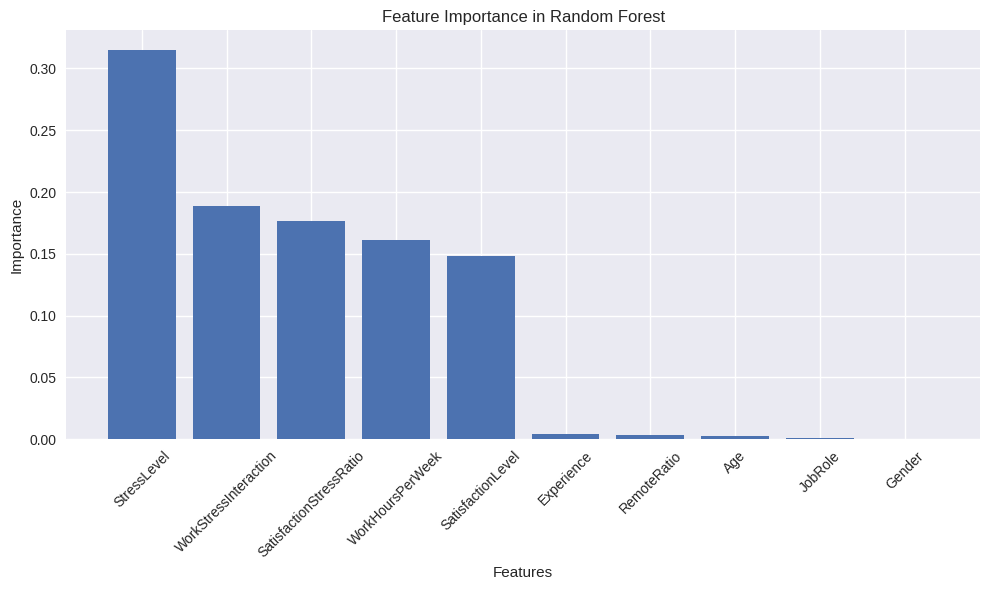

In [98]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

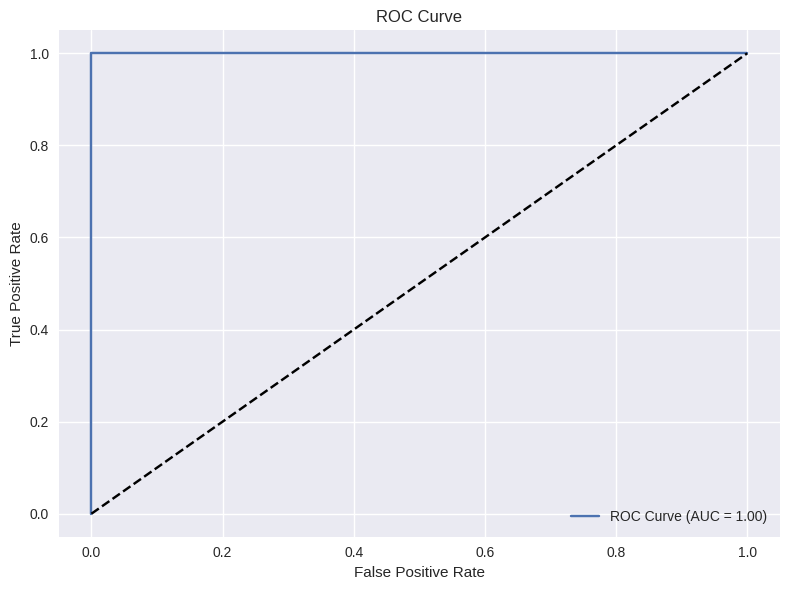

In [99]:
# ROC Curve
y_pred_proba = pipeline.predict_proba(X_test_eng)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [100]:
# Print key metrics
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nFeature Importance Ranking:")
print(feature_importance)

ROC-AUC Score: 1.0000

Feature Importance Ranking:
                   feature  importance
7              StressLevel    0.315124
8    WorkStressInteraction    0.189013
9  SatisfactionStressRatio    0.176146
4         WorkHoursPerWeek    0.160786
6        SatisfactionLevel    0.148098
3               Experience    0.003935
5              RemoteRatio    0.003514
0                      Age    0.002216
2                  JobRole    0.000872
1                   Gender    0.000295


The perfect ROC-AUC and classification metrics suggest the model may have overfit to the training data, possibly due to the synthetic oversampling or leakage. This can is supported by the heavy reliance on engineered features. The negligible importance of original features like Gender and JobRole may indicate insufficient variability or redundancy in the dataset.